In [1]:
from IPython.display import HTML

HTML("""<style>
.lev1 {margin-left: 80px}
.lev2 {margin-left: 100px}
.lev3 {margin-left: 120px}
.lev4 {margin-left: 140px}
.lev5 {margin-left: 160px}
.lev6 {margin-left: 180px}
</style>""")

# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Preparing-the-data" data-toc-modified-id="Preparing-the-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preparing the data</a></div><div class="lev2 toc-item"><a href="#Loading-and-cleaning-the-full-dataset:" data-toc-modified-id="Loading-and-cleaning-the-full-dataset:-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Loading and cleaning the full dataset:</a></div><div class="lev2 toc-item"><a href="#Preparing-the-time-series" data-toc-modified-id="Preparing-the-time-series-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Preparing the time-series</a></div><div class="lev3 toc-item"><a href="#summary-of-distances-popularity" data-toc-modified-id="summary-of-distances-popularity-121"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>summary of distances popularity</a></div><div class="lev3 toc-item"><a href="#only-marathon-runners" data-toc-modified-id="only-marathon-runners-122"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>only marathon runners</a></div><div class="lev3 toc-item"><a href="#only-semi-marathon-runners" data-toc-modified-id="only-semi-marathon-runners-123"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>only semi-marathon runners</a></div><div class="lev1 toc-item"><a href="#Clustering-time-series" data-toc-modified-id="Clustering-time-series-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Clustering time-series</a></div><div class="lev2 toc-item"><a href="#K-nn-+-DTW" data-toc-modified-id="K-nn-+-DTW-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>K-nn + DTW</a></div><div class="lev3 toc-item"><a href="#define-DTW-distance" data-toc-modified-id="define-DTW-distance-211"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>define DTW distance</a></div>

<center><big><b>
 Clustering professional/non-professional on the full Datasport dataset
</b></big></center>

<center>
In this notebook we will also use <i> unsupervised </i> learning techniques to try to distinguish 
<i> professional runner, from non-professional ones. </i>   

More generally, we look for any signature of such distinction that could come from  the features present in our dataset.
</center>

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import datetime
from scipy import stats

import seaborn as sns
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'

import powerlaw 

# Preparing the data

## Loading and cleaning the full dataset:

In [4]:
full_df = pd.read_pickle('../../df_userID.pickle')

#  removing useless features
full_df.drop(['MinTemp','MaxTemp','Weather',
              'LivingPlace','Rank','Category','Name',
              'RaceMonth','RaceID','Place'],axis=1,inplace=True)

global data transformations:

In [5]:
# in order to plot age (@time of the event!) instead of year of birth
full_df['age'] = full_df.RaceYear - full_df.Year

# RaceYear and Year were needed only to compute the runner's age  AT THE year of the events 
full_df.drop('Year',axis=1,inplace=True)
full_df.drop('RaceYear',axis=1,inplace=True)

# Round `Distance` feature:
full_df.Distance = full_df.Distance.round()
full_df.Distance = full_df.Distance.astype('int')

# transform timedelta in minutes!
full_df.Time = full_df.Time.astype('timedelta64[m]')

# transform Pace timedelta in minutes - mind that numbers are  in decimal and NOT in Sexagesimal!
full_df.Pace = round(full_df.Pace.astype('timedelta64[s]')/60.0,2)

# these 2 are actually the same event!
full_df.Race = full_df.Race.apply(
    lambda x: 'Lucerne Marathon, Luzern' if x == 'SwissCityMarathon - Lucerne, Luzern' else x
)

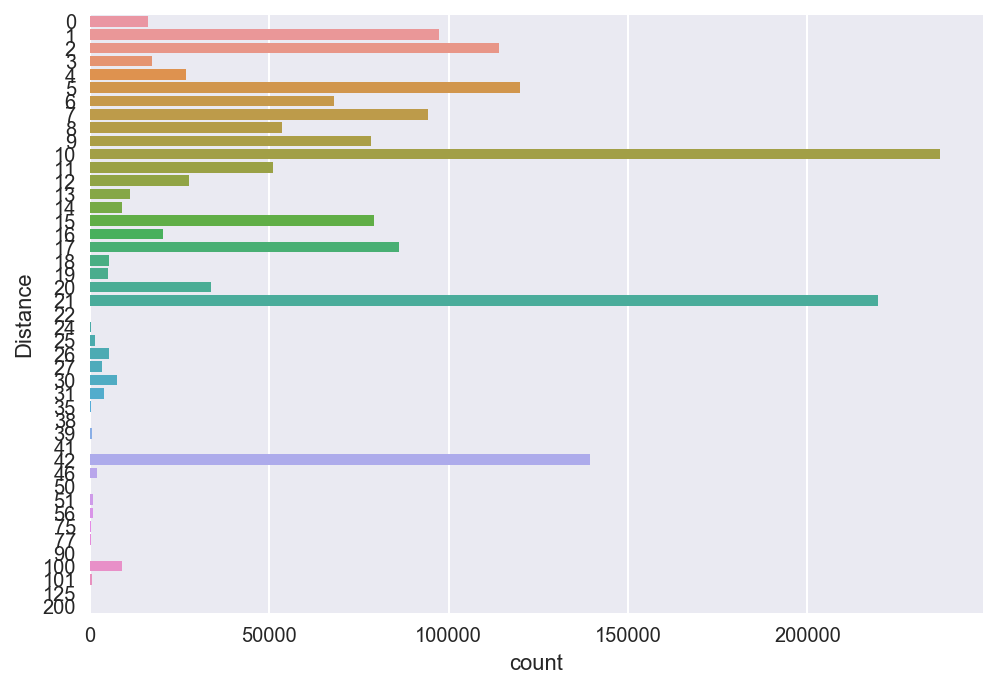

In [30]:
sns.countplot(y=full_df.Distance);

In [6]:
full_df.head()

,Race,Date,Distance,Sex,Time,Pace,UserID,age
0,Kerzerslauf,sam. 18.03.2000,15,M,62.0,4.15,Abgottspon Peter 1974.0,26.0
1,Kerzerslauf,sam. 18.03.2000,15,M,55.0,3.67,Abplanalp Michael 1964.0,36.0
2,Kerzerslauf,sam. 18.03.2000,15,M,72.0,4.83,Abt Werner 1947.0,53.0
3,Kerzerslauf,sam. 18.03.2000,15,F,82.0,5.50,Ackermann Antoinette 1953.0,47.0
4,Kerzerslauf,sam. 18.03.2000,15,F,83.0,5.55,Ackermann Hedy 1946.0,54.0


## Preparing the time-series

In [7]:
print('remember we have',full_df.UserID.nunique(),' unique runners')

remember we have 531426  unique runners


we the __broad distribution__ of the events/runner, that we saw in other notebooks:

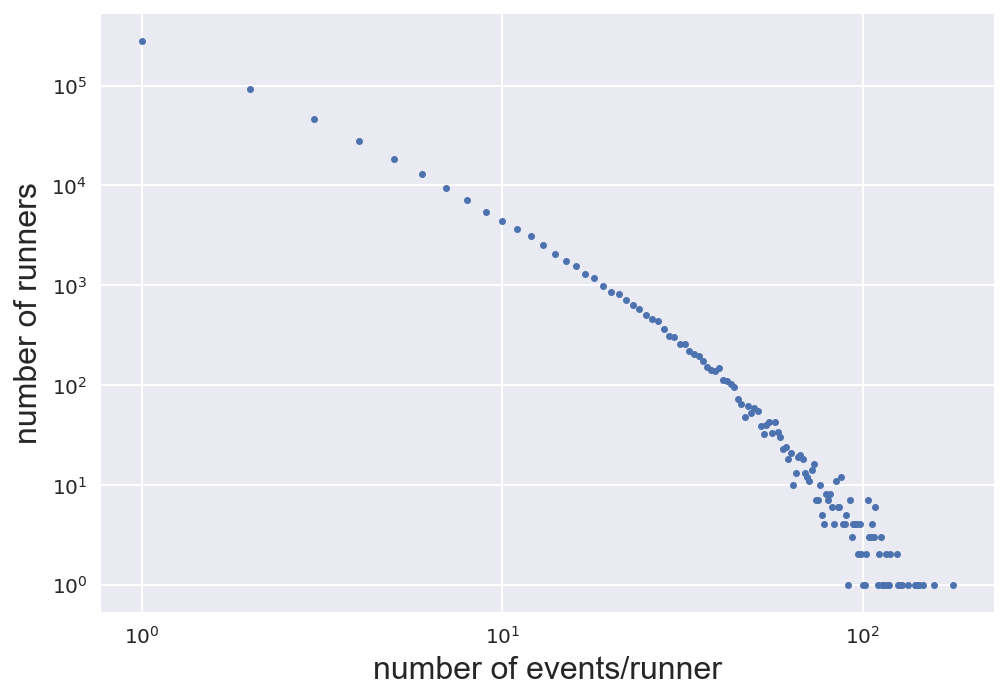

In [8]:
plt.loglog(full_df.UserID.value_counts().value_counts(),marker='.',linestyle='')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('number of events/runner',size=16)
plt.ylabel('number of runners',size=16);

Select runners with __more than $\tau$ races__:

In [9]:
# here we can set the LOWER cut-off we want 
tau = 10

users_by_activity = full_df.UserID.value_counts()
active_users = users_by_activity[users_by_activity.values > tau]

print('number of runners with more than',tau,'races:',
      len(active_users), '-',
      round(len(active_users) / len(users_by_activity) * 100, 2), '% of total')

number of runners with more than 10 races: 27494 - 5.17 % of total


In [40]:
# delete this variable to avoid further confusion
del active_users 

### summary of distances popularity 

We have to select few distances, as of course it doens't make sense to compare performance (time) on different distances.  
It makes sense to choose __only 21/42 Km__, giving the number of participants.

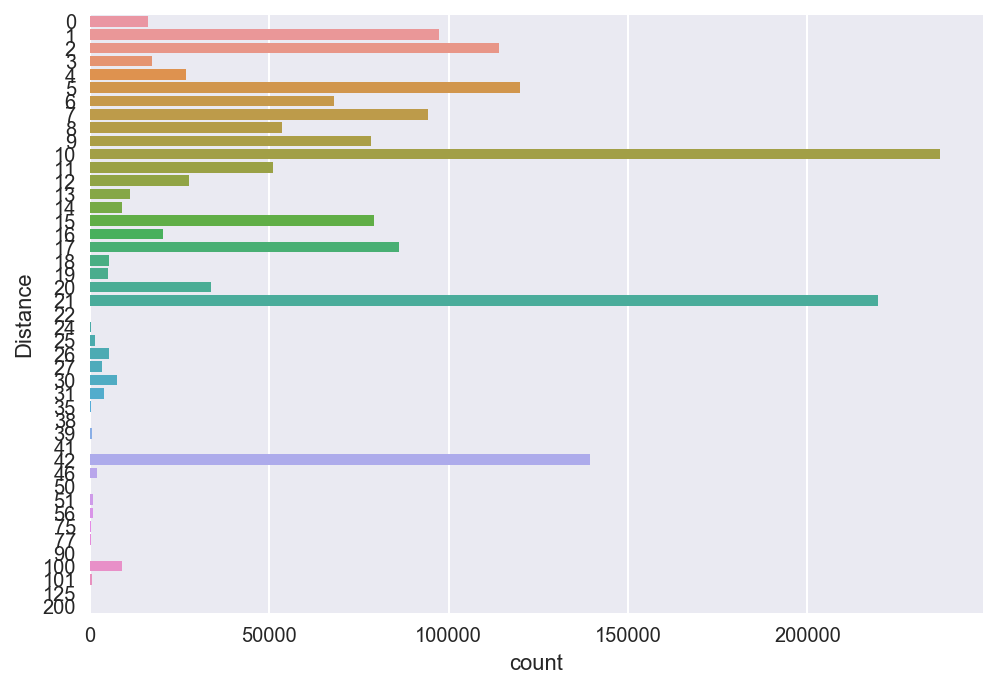

In [37]:
sns.countplot(y=full_df.Distance);

### only marathon runners

### only semi-marathon runners

In [26]:
marathon_full = full_df[full_df.Distance==42]

In [34]:
semi_marathon_full = full_df[full_df.Distance==21]

In [32]:
print(marathon_full.shape)
print('totaal number of samples:', marathon_full.UserID.nunique())

(139271, 8)
totaal number of samples: 68480


In [35]:
print(semi_marathon_full.shape)
print('totaal number of samples:', semi_marathon_full.UserID.nunique())

(219744, 8)
totaal number of samples: 106636


distribution of events/runner for marathon

distribution of events/runner for semi-marathon

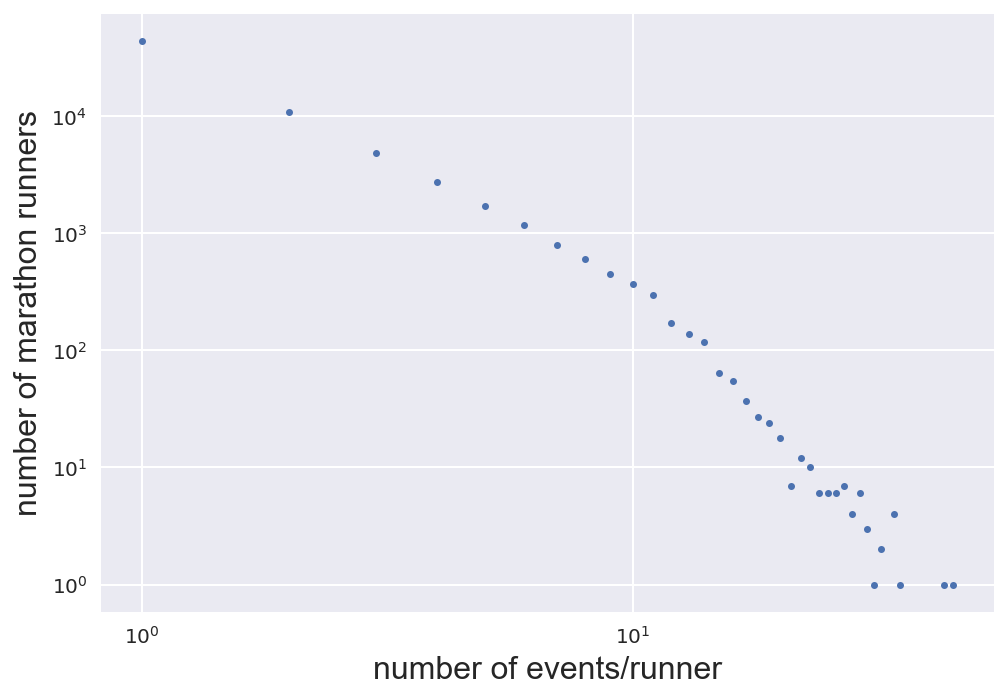

In [33]:
plt.loglog(marathon_full.UserID.value_counts().value_counts(),marker='.',linestyle='')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('number of events/runner',size=16)
plt.ylabel('number of marathon runners',size=16);

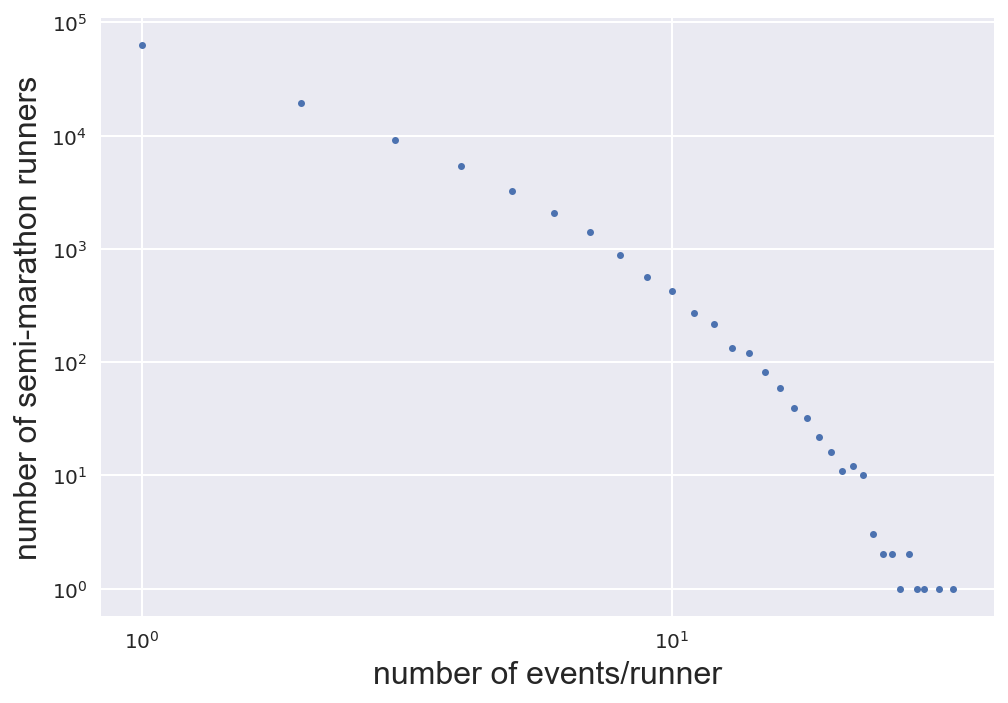

In [36]:
plt.loglog(semi_marathon_full.UserID.value_counts().value_counts(),marker='.',linestyle='')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('number of events/runner',size=16)
plt.ylabel('number of semi-marathon runners',size=16);

In [48]:
# here we can set the LOWER cut-off we want 
tau = 10

marathon_users_by_activity = marathon_full.UserID.value_counts()
active_users_marathon = marathon_users_by_activity[marathon_users_by_activity.values > tau]

print('number of marathon runners with more than',tau,'races:',
      len(active_users_marathon), '-',
      round(len(active_users_marathon) / len(marathon_users_by_activity) * 100, 2), '% of total')

number of marathon runners with more than 10 races: 1024 - 1.5 % of total


In [52]:
# here we can set the LOWER cut-off we want 
tau = 10

semima_users_by_activity = semi_marathon_full.UserID.value_counts()
active_users_semima = semima_users_by_activity[semima_users_by_activity.values > tau]

print('number of semi-marathon runners with more than',tau,'races:',
      len(active_users_semima), '-',
      round(len(active_users_semima) / len(semima_users_by_activity) * 100, 2), '% of total')

number of semi-marathon runners with more than 10 races: 1037 - 0.97 % of total


# Clustering time-series

## K-nn + DTW

How do we tackle this problem in general?   
The 2nd answer in [this post](http://stats.stackexchange.com/questions/66027/time-series-classification-very-poor-results)
on cross-validated mention to type of approaches.    

If we neglect feature-based analysis, the techniques more used (and easier to approach) are 

- the one based on _k-NN_ algorithm (combined with DTW - described 
in [this](https://github.com/alexminnaar/time-series-classification-and-clustering) and 
[this other](https://github.com/markdregan/K-Nearest-Neighbors-with-Dynamic-Time-Warping) github repo )

- the one based on _hierarchical clustering_, described in 
[this other post](http://stackoverflow.com/questions/34940808/hierarchical-clustering-of-time-series-in-python-scipy-numpy-pandas)

(Mind that in our case, the  time-series have clearly __different lenths__. More advanced techniques are collected in [this post](http://stats.stackexchange.com/questions/172439/comparing-clustering-time-series-with-unequal-lengths).)

### define DTW distance 

( credits to the author of
this [nice notebook](http://nbviewer.jupyter.org/github/alexminnaar/time-series-classification-and-clustering/blob/master/Time%20Series%20Classification%20and%20Clustering.ipynb)
)

In [2]:
def DTWDistance(s1, s2):
    DTW={}
    
    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return sqrt(DTW[len(s1)-1, len(s2)-1])